<a href="https://colab.research.google.com/github/tocom242242/aifx_blog_codes/blob/master/anomaly_detection/keras_timeseris_anomaly_detection_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [11]:

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [12]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [13]:
print(df_small_noise.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120


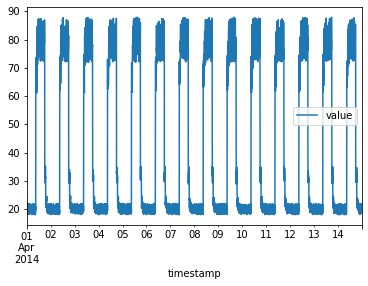

In [14]:
df_small_noise.plot()

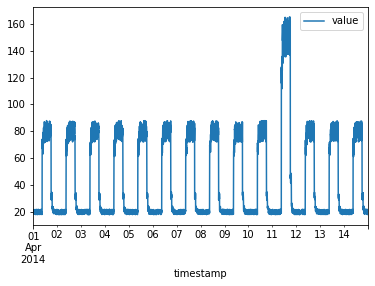

In [15]:
df_daily_jumpsup.plot()

コレログラムを見てみる

<BarContainer object of 4000 artists>

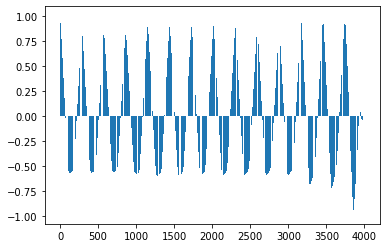

In [16]:
autocorrs = [df_daily_jumpsup["value"].autocorr(lag=lag) for lag in range(4000)]
plt.bar(range(len(autocorrs)),autocorrs)

# Prepare training data

In [17]:

training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


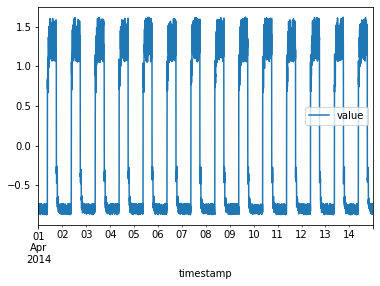

In [18]:
df_training_value.plot()

In [19]:
df_training_value.describe()

,value
count,4.032000e+03
mean,-2.620038e-15
std,1.000000e+00
min,-8.703666e-01
25%,-8.048176e-01
50%,-7.418804e-01
75%,1.175759e+00
max,1.621882e+00


In [20]:
df_training_value.shape

(4032, 1)

In [21]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


In [22]:
len(df_training_value.values)-TIME_STEPS

3744

In [23]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [24]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 87ms/step - loss: 0.7758 - val_loss: 0.1046
Epoch 2/50
27/27 [==============================] - 2s 77ms/step - loss: 0.0958 - val_loss: 0.0371
Epoch 3/50
27/27 [==============================] - 2s 79ms/step - loss: 0.0570 - val_loss: 0.0333
Epoch 4/50
27/27 [==============================] - 2s 79ms/step - loss: 0.0481 - val_loss: 0.0279
Epoch 5/50
27/27 [==============================] - 2s 78ms/step - loss: 0.0415 - val_loss: 0.0262
Epoch 6/50
27/27 [==============================] - 2s 77ms/step - loss: 0.0372 - val_loss: 0.0251
Epoch 7/50
27/27 [==============================] - 2s 78ms/step - loss: 0.0339 - val_loss: 0.0230
Epoch 8/50
27/27 [==============================] - 2s 79ms/step - loss: 0.0314 - val_loss: 0.0217
Epoch 9/50
27/27 [==============================] - 2s 78ms/step - loss: 0.0292 - val_loss: 0.0226
Epoch 10/50
27/27 [==============================] - 2s 79ms/step - loss: 0.0274 - val_loss: 0.0210
Epoch 11/

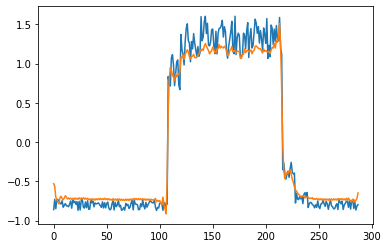

In [25]:
x_train_pred = model.predict(x_train)
plt.plot(x_train[0])
plt.plot(x_train_pred[0])

In [26]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

In [27]:
train_mae_loss

array([[0.10991927],
       [0.11076423],
       [0.11018656],
       ...,
       [0.11150303],
       [0.11358676],
       [0.10955423]])

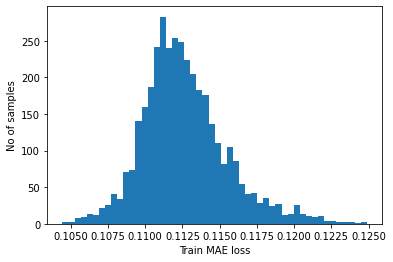

Reconstruction error threshold:  0.1248834796715283


In [28]:
# 誤差の分布を表示する
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [29]:
x_train_pred.shape

(3744, 288, 1)

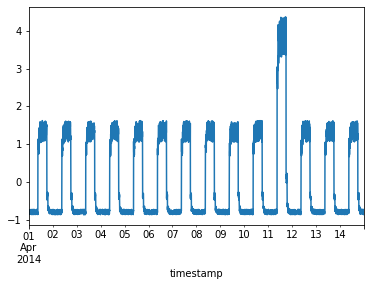

Test input shape:  (3744, 288, 1)


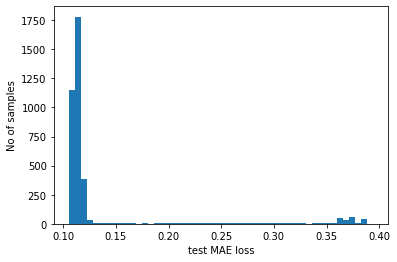

Number of anomaly samples:  407
Indices of anomaly samples:  (array([ 787,  795, 1650, 1651, 1652, 1654, 1658, 1659, 1660, 2522, 2523,
       2695, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2

In [30]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [31]:
# 異常であればTrue
anomalies

array([False, False, False, ..., False, False, False])

In [32]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    # 指定した範囲すべてが異常なら異常値に含む
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

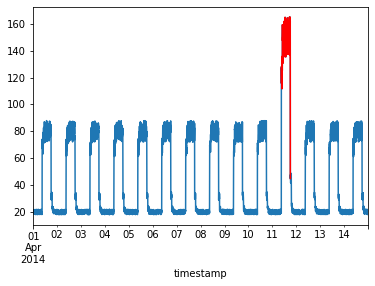

In [33]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

In [34]:
df_subset

,value
timestamp,
2014-04-11 09:00:00,127.882020
2014-04-11 09:05:00,115.705719
2014-04-11 09:10:00,122.386410
2014-04-11 09:15:00,127.261178
2014-04-11 09:20:00,121.157997
...,...
2014-04-11 17:40:00,156.009099
2014-04-11 17:45:00,164.947481
2014-04-11 17:50:00,145.758267
